In [1]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.recommend.user_knn as uk
from src.recommend.utils import *
import tqdm
import warnings
import matplotlib

In [10]:
def convert_vector(b):
    n = len(b)
    valid_idx = np.where(~np.isnan(b))[0] #2d vector of nx1, only want row index of valid values
    D0 = np.ones([n, len(valid_idx)])
    for i, val in enumerate(valid_idx):
        D0[val, i] = np.nan
    BD0 = b * D0 # broacast
    return BD0

In [3]:
d = './processed/filtered/'
album_df, user_dfs = load_dataframes(d)
(user_train_df, user_val_df, user_test_df) = user_dfs

In [4]:
X_train = generate_user_item_matrix(user_train_df, album_df)
X_val = generate_user_item_matrix(user_val_df, album_df)
X_test = generate_user_item_matrix(user_test_df, album_df)

In [5]:
# convert from user-rating to rating-user
X_train = X_train.T
X_test = X_test.T

In [6]:
#convert 0 to Nan
X_train = X_train.astype('float')
X_test = X_test.astype('float')
X_train[X_train == 0.0] = np.nan
X_test[X_test == 0.0] = np.nan

### Strong Generalization

In [8]:
uk = uk.UserKNN(X_train)

In [ ]:
P_list = []
for i in range(3):
    b = X_test[:,i].reshape([-1,1])
    uk.B = convert_vector(b)
    uk.b_valid_idx = np.where(~np.isnan(b))[0]
    uk.gen_M(strong=True)
    uk.gen_mu(strong=True)
    uk.gen_corrcoef(strong=True) # one vector of test data, 3:22 (17,733 train vectors, 86 test vectors perturbations)
    uk.gen_preds(strong=True)
    P_list.append(uk.P_strong)
    

In [12]:
b_true_list = []
b_valid_len = []
for i in range(3):
    b = X_test[:,i].reshape([-1,1])
    b_valid_idx = np.where(~np.isnan(b))[0]
    b_true = np.array([b[i] for i in b_valid_idx]).squeeze()
    b_true_list.append(b_true)
    b_valid_len.append(len(b_true))


### Performance
Mean absolute error for each test user

In [52]:
for i, P in enumerate(P_list):
    print("---")
    print(f"Number of ratings for test user {i}: {len(P)}")
    print(f"Mean absolute error: {round(np.mean(abs(P - b_true_list[i])),2)}")
    

---
Number of ratings for test user 0: 86
Mean absolute error: 9.06
---
Number of ratings for test user 1: 226
Mean absolute error: 6.15
---
Number of ratings for test user 2: 12
Mean absolute error: 4.56


In [47]:
P = []
b_true = []
for p in P_list:
    P.extend(p)
for b in b_true_list:
    b_true.extend(b.tolist())


In [50]:
len(b_true)

324

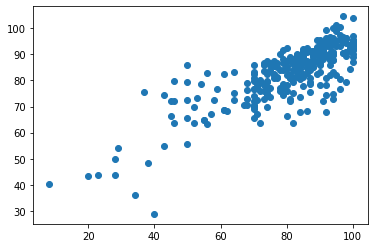

In [51]:
plt.scatter(b_true, P)